In [1]:
from dataset import SiTDataset
from tqdm import tqdm
import os
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_2, SiT_B_8
import lpips
from PIL import Image
import numpy as np
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

/home/d/dziri/venvs/jlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- check distro of latent pose - CHECK
- calling the model directly
- plot poses in 3d
- use torch metrics - CHECK

In [2]:
psnr = PeakSignalNoiseRatio(data_range=255).cuda()
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').cuda()

def get_pose_radius(pose):
    translation_vector = pose[:3, 3]
    radius = torch.norm(translation_vector)
    
    return radius

def evaluate_prediction(ground_truth, prediction):
    ground_truth = ground_truth.clamp(0, 255)
    prediction = prediction.clamp(0, 255)
    
    psnr_value = psnr(prediction, ground_truth) #(N,C,H,W)

    mae = torch.mean(torch.abs(ground_truth - prediction))

    ground_truth = ground_truth.div(255.0).mul(2).sub(1).clamp(-1, 1)
    prediction = prediction.div(255.0).mul(2).sub(1).clamp(-1, 1)

    lpips_value = lpips(prediction, ground_truth)

    return psnr_value.item(), lpips_value.item(), mae.item()

/home/d/dziri/venvs/jlab/lib/python3.12/site-packages/torchmetrics/functional/image/lpips.py:332: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.lo

In [38]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/000-SiT-B-8-Linear-velocity-None/checkpoints/0072000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')


In [39]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [40]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )

In [41]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1], inplace=True)
])

dataset = SiTDataset("data/chair_data/test", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

In [45]:
from torchvision.utils import save_image
import torch
from tqdm import tqdm

max_pairs = 10                    # how many GT/pred rows to keep
gt_pool, pred_pool = [], []       # hold first 10 pairs for final sheet

total_psnr = total_mae = total_lpips = 0.0
plot_data = []
radii = []
i = 0
with torch.inference_mode(): 
    for image, gaussian_pose, gt_pose, noise in tqdm(eval_loader, "Evaluating model..."):
        image = image.to("cuda")
        gaussian_pose  = gaussian_pose.to("cuda")
        radius = round(get_pose_radius(gt_pose[0]).item(), 2)

        n = ys.size(0)
        y = torch.IntTensor([0]).to(device)
        z = torch.cat([gaussian_pose, gaussian_pose], 0)
        y_null = torch.tensor([1] * n, device="cuda")
        y = torch.cat([y, y_null], 0)
        model_kwargs = dict(y=y, cfg_scale=cfg_scale)
    
        samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
        samples = vae.decode(samples / 0.18215).sample
        
        samples = samples[0].unsqueeze(0)
        
        psnr_value, lpips_value, mae = evaluate_prediction(image, samples)
        
        plot_data.append([radius, psnr_value, lpips_value, mae])
        total_psnr += psnr_value
        total_lpips += lpips_value
        total_mae  += mae
        
        if len(gt_pool) < max_pairs:
            gt_pool.append(image[0].cpu())
            pred_pool.append(samples[0].cpu())

        if i == 100:
            break
        else:
            i += 1

if gt_pool:
    sheet_images = torch.stack(
        [im for pair in zip(gt_pool, pred_pool) for im in pair]
    ) 

    save_image(
        sheet_images,
        "gt_vs_pred_first10.png",
        nrow=2,
        padding=2,
        normalize=True,
        value_range=(-1, 1)
    )

num_batches = len(eval_loader)
total_psnr /= num_batches
total_lpips  /= num_batches
total_mae  /= num_batches

print("PSNR:", total_psnr)
print("LPIPS:", total_lpips)
print("MAE: ", total_mae)

Evaluating model...:   3%|██▍                                                                       | 100/3000 [01:07<32:49,  1.47it/s]

PSNR: 2.2854612070719402
LPIPS: 0.01539103353570681
MAE:  4.568226732313633


In [35]:
max(radii)

5.03

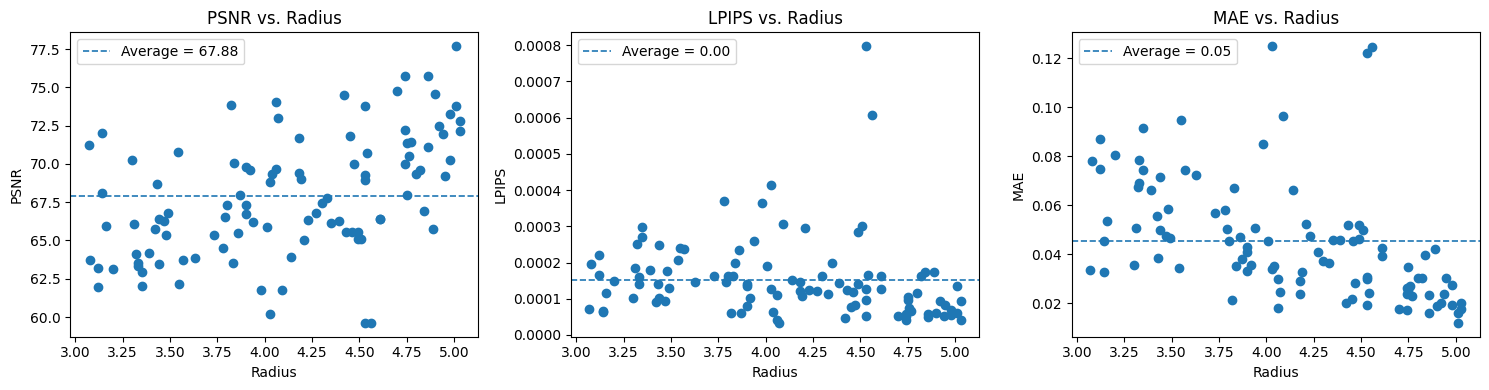

In [47]:
import numpy as np
import matplotlib.pyplot as plt

data   = np.array(plot_data, dtype=float)
data   = data[data[:, 0].argsort()]

radius = data[:, 0]
psnr   = data[:, 1]
lpips    = data[:, 2]
mae    = data[:, 3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

def add_panel(ax, y, y_label, title):
    ax.plot(radius, y, marker='o', linestyle='none')      # ← changed line
    ax.axhline(y.mean(), ls='--', lw=1.2,
               label=f'Average = {y.mean():.2f}')
    ax.set_xlabel('Radius')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

add_panel(axes[0], psnr, 'PSNR', 'PSNR vs. Radius')
add_panel(axes[1], lpips,  'LPIPS',  'LPIPS vs. Radius')
add_panel(axes[2], mae,  'MAE',  'MAE vs. Radius')

plt.tight_layout()

fig.savefig("radius_metrics.png", dpi=300, bbox_inches="tight")

plt.show()


# Test invertibility of SiT

In [3]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/000-SiT-B-8-Linear-velocity-None/checkpoints/0072000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')

/home/d/dziri/big/SiT/SiT/download.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage)


In [4]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [5]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
        reverse=True
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5" 

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode_backwards(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps,
        reverse=False
    )

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1], inplace=True)
])

dataset = SiTDataset("data/chair_data/test", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

In [7]:
import torch
import numpy as np

import torch

def extract_original_pose(denoised_pose, pose_mean, pose_std):
    # denoised_pose is in shape 4x16x16
    # need to reverse standardization
    stdized_pose_flat = []
    
    for i in range(4):
        first = torch.mean(denoised_pose[i, :8, :8])
        second = torch.mean(denoised_pose[i, :8, 8:])
        third = torch.mean(denoised_pose[i, 8:, :8])
        fourth = torch.mean(denoised_pose[i, 8:, 8:])
        stdized_pose_flat.extend([first, second, third, fourth])

    stdized_pose_tensor = torch.FloatTensor(stdized_pose_flat)

    original_pose_flat = (stdized_pose_tensor * pose_std) + pose_mean
    
    original_pose = torch.reshape(original_pose_flat, (4, 4))

    return original_pose

def calculate_translation_error(ground_truth, prediction):
    prediction = prediction.to("cuda")
    ground_truth_translation = ground_truth[0:3, 3]
    prediction_translation = prediction[0:3, 3]
    
    distance = torch.sqrt(torch.sum(torch.pow(torch.subtract(ground_truth_translation, prediction_translation), 2), dim=0)) 

    return distance.item()

def calculate_rotation_error(ground_truth, prediction):
    ground_truth = ground_truth.to("cuda")
    prediction = prediction.to("cuda")
    
    ground_truth_rotation = ground_truth[:3, :3]
    prediction_rotation = prediction[:3, :3]
    prediction_rotation = prediction_rotation.type(torch.FloatTensor).to("cuda")

    dot_product = ground_truth_rotation.T @ prediction_rotation

    trace = torch.trace(dot_product)

    cos_arg = torch.clamp((trace - 1) / 2, -1.0, 1.0)

    result = torch.acos(cos_arg)

    result_deg = torch.rad2deg(result)

    return result_deg.item()

def evaluate_poses(ground_truth, prediction):

    translation_error = calculate_translation_error(ground_truth, prediction)

    rotation_error = calculate_rotation_error(ground_truth, prediction)
    
    return translation_error, rotation_error

In [8]:
#Iterate over testset loader, get image, pose
total_translation_error = 0
total_rotation_error = 0
plot_data = []
pose_gt = []
pose_pred = []

i = 0
for image, gaussian_pose, gt_pose, noise in tqdm(eval_loader, "Evaluating model..."):

    noise = noise.to("cuda")[0]
    gaussian_pose = gaussian_pose.to("cuda")
    gt_pose = gt_pose.to("cuda")
    image = image.to("cuda")

    posterior = vae.encode(image)[0]
    image = posterior.sample()
    image = image * 0.18215

    radius = get_pose_radius(gaussian_pose)
    radius = round(radius.item(), 2)
    
    n = ys.size(0)
    y = torch.IntTensor([0]).to(device)
    z = torch.cat([image, image], 0)
    y_null = torch.tensor([1] * n, device="cuda")

    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)

    samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]

    #HERE was the error, I had samples = samples[0][0]

    denoised_pose = samples - noise
    
    reconstructed_pose = extract_original_pose(denoised_pose, dataset.pose_mean,dataset.pose_mean)
    
    pose_pred.append(reconstructed_pose.cpu().detach().numpy())
    pose_gt.append(gt_pose[0].cpu().detach().numpy())

    if i == 50:
        break
    else:
        i += 1 
    
    translation_error, rotation_error = evaluate_poses(gt_pose[0], reconstructed_pose)
    
    plot_data.append([radius, translation_error, rotation_error])
    
    total_translation_error += translation_error
    total_rotation_error += rotation_error

total_translation_error /= eval_loader.__len__()
total_rotation_error /= eval_loader.__len__()

print("translation error:", total_translation_error)
print("rotation_error:", total_rotation_error)

Evaluating model...:   0%|                                                                                    | 0/3000 [00:00<?, ?it/s]/tmp/user/25324/ipykernel_853613/3694303449.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  original_pose_flat = (stdized_pose_tensor * pose_std) + pose_mean
Evaluating model...:   2%|█▏                                                                       | 50/3000 [01:41<1:40:05,  2.04s/it]

translation error: 0.05494584834575653
rotation_error: 1.4169315134684244


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_pose_lists(gt_poses, pred_poses, axis_length=0.1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def plot_single_pose(pose, ax, axis_length, base_color='k', alpha=1.0, label_prefix=None):
        R = pose[:3, :3]
        t = pose[:3, 3]

        # Axis endpoints
        x_axis = t + axis_length * R[:, 0]
        y_axis = t + axis_length * R[:, 1]
        z_axis = t + axis_length * R[:, 2]

        # Plot origin
        ax.scatter(*t, color=base_color, s=10, alpha=alpha)

        # Plot orientation axes (x=red, y=green, z=blue)
        ax.plot([t[0], x_axis[0]], [t[1], x_axis[1]], [t[2], x_axis[2]], c='r', alpha=alpha)
        ax.plot([t[0], y_axis[0]], [t[1], y_axis[1]], [t[2], y_axis[2]], c='g', alpha=alpha)
        ax.plot([t[0], z_axis[0]], [t[1], z_axis[1]], [t[2], z_axis[2]], c='b', alpha=alpha)

    # Plot GT poses
    for pose in gt_poses:
        plot_single_pose(pose, ax, axis_length, base_color='green', alpha=1.0)

    # Plot predicted poses
    for pose in pred_poses:
        plot_single_pose(pose, ax, axis_length, base_color='red', alpha=0.6)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Ground Truth vs Prediction')
    ax.set_box_aspect([1, 1, 1])

    # Create manual legend
    gt_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Ground Truth', markersize=6)
    pred_proxy = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Predicted', markersize=6)
    ax.legend(handles=[gt_proxy, pred_proxy])

    plt.tight_layout()
    plt.show()


In [14]:
print(pose_pred[0][:3, 3])
print(pose_pred[1][:3, 3])
print(pose_pred[2][:3, 3])
print(pose_pred[3][:3, 3])

[-0.15156613  0.09638038  1.3932078 ]
[-0.09200209 -0.00504588  2.3381076 ]
[-0.08830665  0.12130895  4.5565405 ]
[0.00315177 0.00421246 0.78942895]


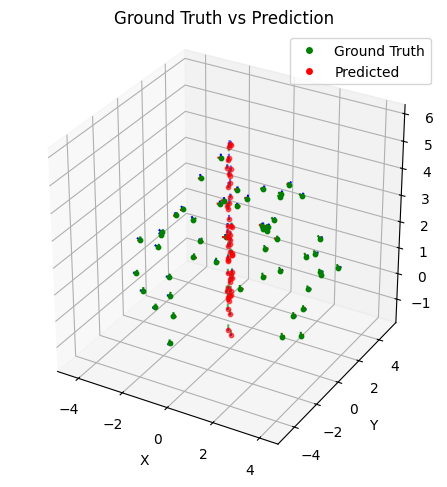

In [11]:
plot_pose_lists(pose_gt, pose_pred)